<hr>
<font size=5 color='#543ba3'> <b> Wine Classification - K. Weigel </b> </font> 
<hr/>
<font color='#543ba3'>
    
- [1 - Introduction](#1)
- [2 - Exploratory data analysis](#2)
- [3 - Preparing the data](#3)
    - [3.1 - Train test split](#3-1)
    - [3.2 - Scaling](#3-2)
- [4 - Classification models](#4)
    - [4.1 Performance metrics](#4-1)
    - [4.2 One-vs-all logistic regression](#4-2)
    - [4.3 K-nearest neighbors](#4-3)
    - [4.4 Principal component analysis](#4-4)
        - [4.4.1 Logistic regression with PCA features](#4-4-1)
        - [4.4.2 KNN with PCA features](#4-4-1)
    - [4.5 Fisher's linear discriminant analysis](#4-5)
        - [4.5.1 Logistic regression with LDA features](#4-5-1)
        - [4.5.2 KNN with LDA features](#4-5-2)
    - [4.6 Random forest classifier](#4-6)
        - [4.6.1 Decision tree](#4-6-1)
        - [4.6.2 Bagging](#4-6-2)
        - [4.6.3 Random forest](#4-6-3)
        - [4.6.4 Hyperparameter tuning](#4-6-4)
- [5 - Summary](#5)
</font>

<a name='1'></a>
# 1 - Introduction

The wine data set (https://archive.ics.uci.edu/dataset/109/wine) contains 13 different characteristics of wine such as alcohol and ash content which were measured for 178 wine samples. These wines were grown in the same region in Italy but were derived from three different cultivars; therefore there are three different classes of wine. The goal of this project is to find a model that can predict the class of wine given the 13 measured parameters. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import LinearSegmentedColormap
from sklearn import set_config
set_config(display='text')

%matplotlib inline

palette = ['#543ba3', '#95bbe8', '#b058c6']

sns.set_palette(palette)
cmap = LinearSegmentedColormap.from_list('custom', ['#eff9ff', '#95bbe8', '#543ba3', '#371f4e'])
cmap2 = LinearSegmentedColormap.from_list('custom', ['#95bbe8', '#543ba3', '#b058c6'])

In [2]:
wine_data = pd.read_csv('wine.data', header=None)

In [3]:
wine_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
wine_data.columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                     'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

In [5]:
wine_data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
wine_data.shape

(178, 14)

<a name='2'></a>
# 2 - Exploratory data analysis 

First we will visualize the dataset, to get a better understanding of the relationships between variables, check for potential outliers.

<AxesSubplot:xlabel='Class', ylabel='count'>

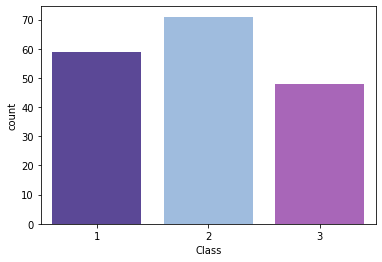

In [7]:
sns.countplot(x=wine_data['Class'])

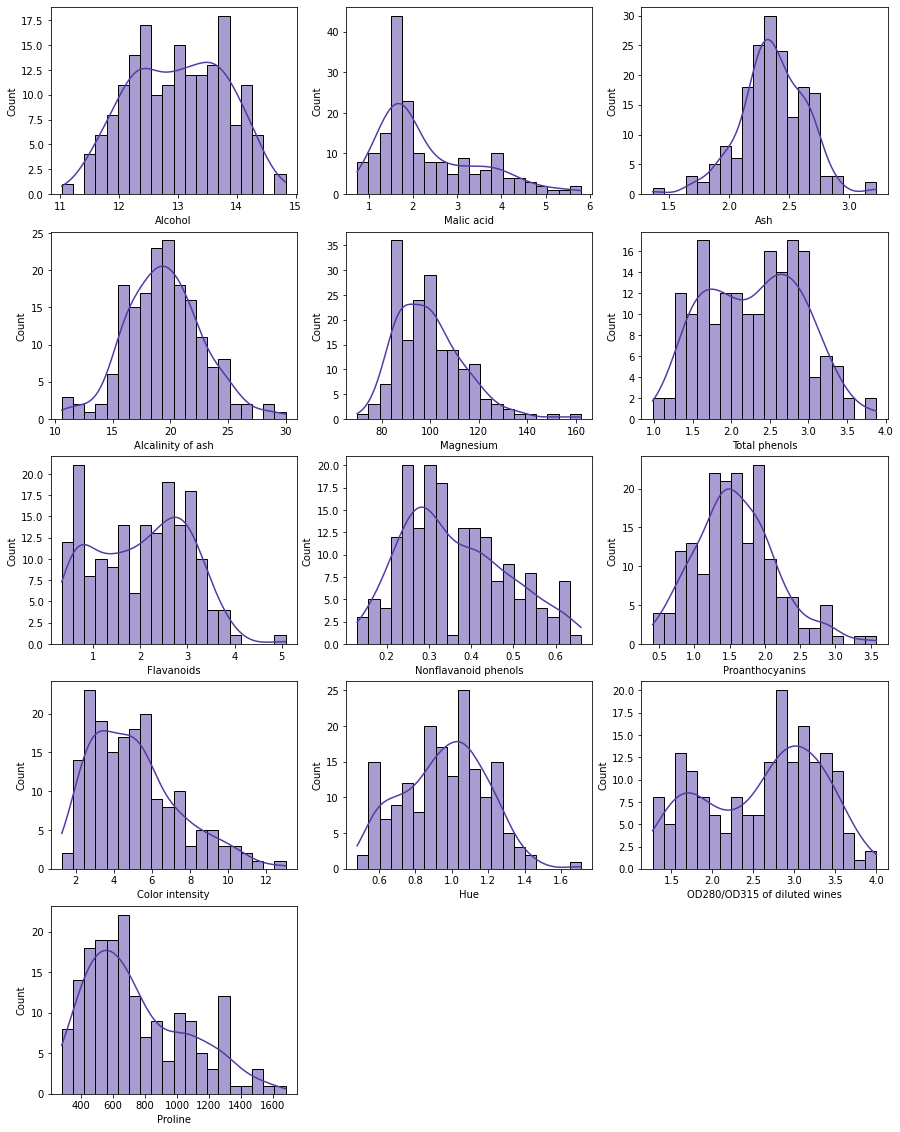

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

for i, column in enumerate(wine_data.drop('Class', axis=1).columns):
    sns.histplot(wine_data[column], ax=axes[i//3, i%3], kde=True, bins=20)

fig.delaxes(axes[-1, -1])
fig.delaxes(axes[-1, -2])

There are no obvious outlier measurements. 

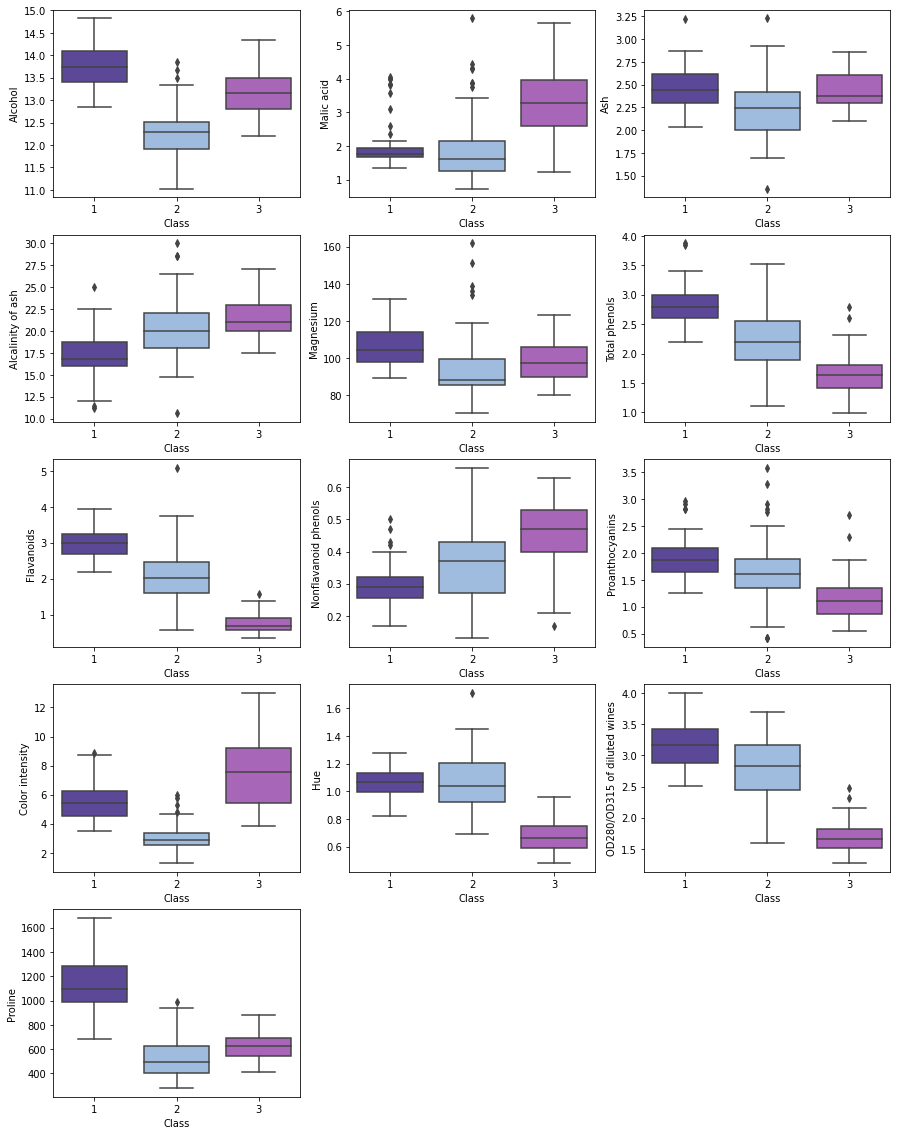

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

for i, column in enumerate(wine_data.drop('Class', axis=1).columns):
    sns.boxplot(data=wine_data, x='Class', y=column, ax=axes[i//3, i%3])

fig.delaxes(axes[-1, -1])
fig.delaxes(axes[-1, -2])

Most of the features seem to have some influence on the resulting class. 

<AxesSubplot:>

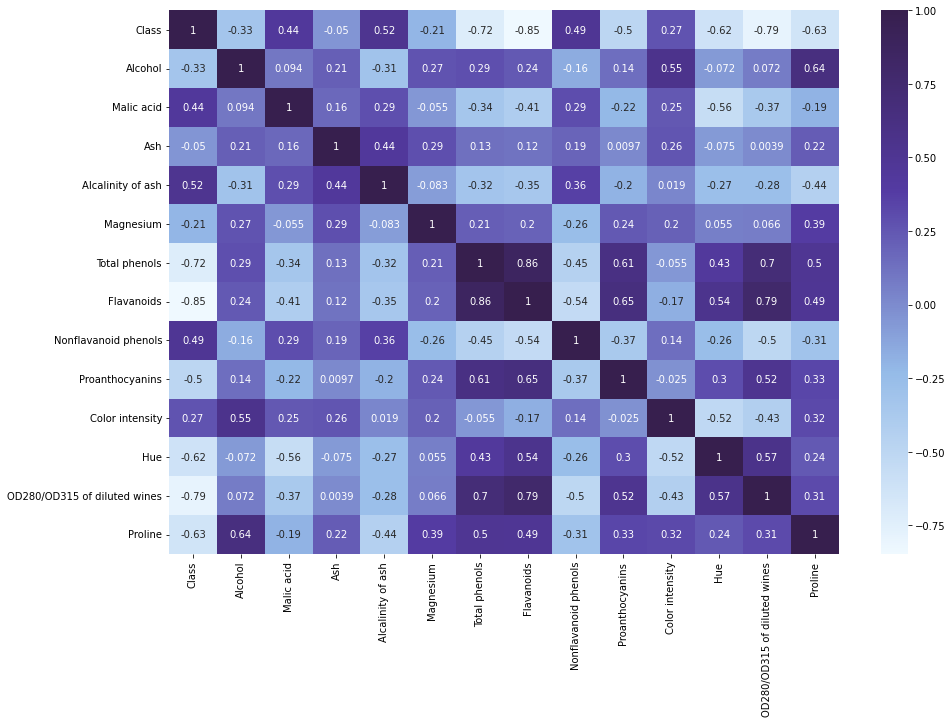

In [10]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(wine_data.corr(), annot=True, cmap=cmap)

<a name='3'></a>
# 3 - Preparing the data

<a name='3-1'></a>
## 3.1 - Train test split

We split the data into training and testing (validation) data sets, with 70% of the data used for training.

In [11]:
X, y = wine_data.iloc[:, 1:].values, wine_data.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 101, 
                                                    stratify=y)

<a name='3-2'></a>
## 3.2 - Scaling

Because our dataset contains a lot of variables that are on different scales we should apply scaling. The scaling makes training faster (gradient descent converges faster), and for some algorithms, which are distance-based, scaling is crucial.

We perform standard scaling, where we subtract the mean and divide by the standard deviation.

$$
Z = \frac{X - \mu}{\sigma}.
$$

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

<a name='4'></a>
# 4 - Classification models

Now we will try to classify the data with various classification models.

<a name='4-1'></a>
## 4.1 - Performance metrics

Before fitting our models let us define performance metrics, used to measure how good the model is.

* True positive (TP) - predicted label = 1, true label = 1
* False positive (FP) - predicted label = 1, true label = 0
* True negative (TN) - predicted label = 0, true label = 0
* False negative (FN) - predicted label = 0, true label = 1

Precision is defined as the number of discoveries that are relevant (true positives), out of the total discoveries the model retrieved.

$$
\text{Precision} = \frac{TP}{TP + FP}.
$$

In other words precision measures how often our model is right, when it makes a discovery (label = 1). We want to maximize precision especially in cases, when it is dangerous to make a false discovery. A good example would be predicting a presence of a disease with dangerous treatment. In such scenario we want to avoid diagnosing patients with the disease, if they don't have it. 

Recall or true-positive-rate is defined as

$$
\text{Recall} = \frac{TP}{TP + FN}.
$$

Maximizing recall would result in a model making more discoveries, which in turn would mean an increase in the number of false positives. We may want prioritize this metric when classifying patients with a disease, which treatment methods are relatively free of side-effects, and if the disease were to be left untreated it could cause serious damage.

In multiclass classification using One-vs-All regression, we use micro and macro averaging to compute the scores:

$$
PRE_{micro} = \frac{TP_1 + \dots + TP_k}{TP_1 + \dots + TP_k + FP_1 + \dots + FP_k},
$$

$$
PRE_{macro} = \frac{PRE_1 + \dots + PRE_k}{k}.
$$


<a name='4-2'></a>
## 4.2 - One-vs-all logistic regression

First we are going to introduce the concept of binary logistic regression model. The goal of logistic regression is to correctly estimate the probability $P(y = 1 | \textbf{x})$. We assume that the responses come from the Bernoulli distribution

$$
\hat{P}(y | \textbf{x}) = \sigma(\textbf{w}^T\textbf{x} + b),
$$

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

Since $\hat{P} (y | \textbf{x})$ can either be equal to $\hat{P} (0 | \textbf{x})$ or $\hat{P} (1 | \textbf{x})$, we can write it as,

$$
\hat{P} (y | \textbf{x}) = \hat{P} (1 | \textbf{x})^y \times \hat{P} (0 | \textbf{x})^{1 - y} = \hat{P} (1 | \textbf{x})^y \times (1 - \hat{P} (1 | \textbf{x}))^{1 - y}.
$$

Let us now consider $n$ training examples. We want to estimate the weights $\textbf{w}$, so that the log-likelihood of our data under the estimated parameters is maximized.

$$
\begin{aligned}
\mathcal{l}(\textbf{w}, b) &= \text{log} \prod_{i = 1}^n \hat{P} (y_i | \textbf{x}_i ; \textbf{w}, b)\\
&= \sum_{i = 1}^n y_i \text{ log }\hat{P} (1 | \textbf{x}_i) + (1 - y_i)\text{ log }(1 - \hat{P} (1 | \textbf{x}_i)) \\
&= \sum_{i=1}^n  y_i \text{ log }\sigma(\textbf{w}^T\textbf{x}_i) +  (1 - y_i) \text{ log }(1 - \sigma(\textbf{w}^T\textbf{x}_i)).
\end{aligned}
$$

The cost function is:

$$
J(\textbf{w}) = - \frac{1}{n} \sum_{i=1}^n y_i \text{ log }\sigma(\textbf{w}^T\textbf{x}_i) +  (1 - y_i) \text{ log }(1 - \sigma(\textbf{w}^T\textbf{x}_i)).
$$

In order to compute optimal parameters we use gradient descent method.


One-vs-all (or One-vs-rest) model breaks down $k$ classes present in our dataset into $k$ binary classifier models that aims to classify a data point as either part of the current class $k_i$ or as part of all other classes. 


In [13]:
dict_acc = dict()

In [14]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr')

lr.fit(X_train_std, y_train)

LogisticRegression(multi_class='ovr')

In [15]:
dict_acc['Logistic regression'] = [lr.score(X_train_std, y_train), lr.score(X_test_std, y_test)]

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 0.9629629629629629


In [16]:
print(classification_report(y_test, lr.predict(X_test_std)))

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       1.00      0.90      0.95        21
           3       0.94      1.00      0.97        15

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54



In [17]:
def plot_cm(model, X, y):
    predictions = model.predict(X)
    cm = confusion_matrix(y, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=cmap, colorbar=False)

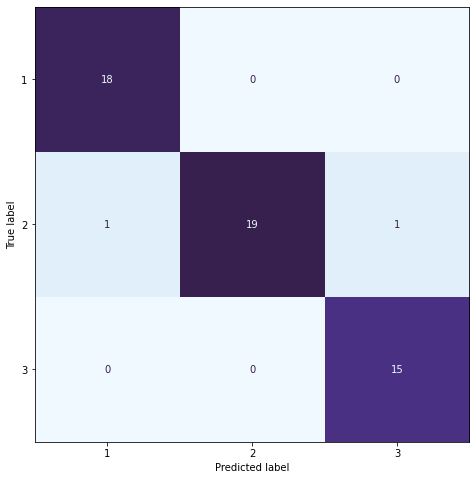

In [18]:
plot_cm(lr, X_test_std, y_test)

<a name='4-3'></a>
## 4.3 - K-nearest neighbors (KNN)

In KNN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its $k$ nearest neighbors. 

More formally let's say we have a test point $\textbf{x}$, and the set of $k$ nearest neighbors of of is $S_{\textbf{x}}$. Then the following must hold:

$$
\forall_{(\textbf{x}', y') \in D \backslash S_{\textbf{x}}} \ \  \text{dist} (\textbf{x}, \textbf{x}') \geq 
\max_{(\textbf{x}'', y'') \in S_{\textbf{x}}} \ \  \text{dist} (\textbf{x}, \textbf{x}'').
$$

We can then define the classifier h() as a function returning the most common label in $S_{\textbf{x}}$: 

$$
h(\textbf{x}) = \text{mode}(\{y'': (\textbf{x}'', y'') \in S_{\textbf{x}} \}).
$$

There are a few possible choices for the distance function, some of the most common ones include
* Minkowski distance
$$
\text{dist}(\textbf{x}, \textbf{z}) = \left( \sum_{j=1}^p |x_j - z_j|^{\alpha} \right)^{1/\alpha}
$$
* Manhattan distance (Minkowski distance for $\alpha = 1$)
$$
\text{dist}(\textbf{x}, \textbf{z}) = \sum_{j=1}^p |x_j - z_j|
$$
* Euclidean distance (Minkowski distance for $\alpha = 2$)
$$
\text{dist}(\textbf{x}, \textbf{z}) = \sqrt{\sum_{j=1}^p |x_j - z_j|^2}
$$
* Cosine distance
$$
\text{dist}(\textbf{x}, \textbf{z}) = \frac{\textbf{x} \cdot \textbf{z}}{\lVert \textbf{x} \rVert  \lVert \textbf{z} \rVert}
$$

In [19]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_std, y_train)

KNeighborsClassifier(n_neighbors=3)

In [20]:
dict_acc['KNN'] = [knn.score(X_train_std, y_train), knn.score(X_test_std, y_test)]

print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9444444444444444


In [21]:
print(classification_report(y_test, knn.predict(X_test_std)))

              precision    recall  f1-score   support

           1       0.90      1.00      0.95        18
           2       1.00      0.86      0.92        21
           3       0.94      1.00      0.97        15

    accuracy                           0.94        54
   macro avg       0.95      0.95      0.95        54
weighted avg       0.95      0.94      0.94        54



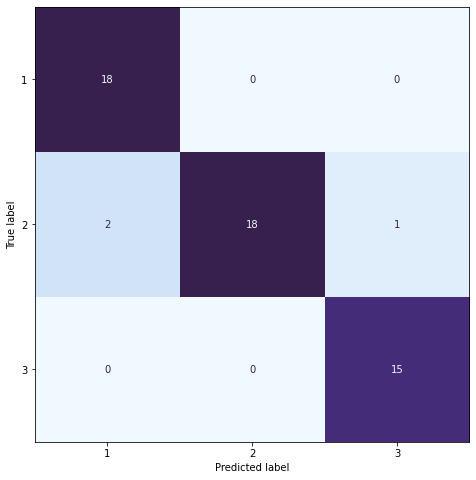

In [22]:
plot_cm(knn, X_test_std, y_test)

<a name='4-4'></a>
## 4.4 - Principal component analysis (PCA)

Given a matrix $\textbf{X} \in \mathbb{R}^{n\times p}$, we want a vector $\textbf{w} \in \mathbb{R}^{p}$ that maximizes the variance of $\textbf{Xw}$ (var($\textbf{Xw}$) = $\textbf{w}^T cov(\textbf{X}) \textbf{w}$) subject to $\| \textbf{w}\|^2 =1$. Let $\text{cov}(\textbf{X}) = \Sigma$.

$$
\max_{\textbf{w}} \textbf{w}^T \Sigma \textbf{w}, \quad  \text{ subject to } \| \textbf{w} \|^2 =1.
$$

We can solve the above problem using Lagrange multipliers. The Lagrangian is:

$$
L(\textbf{w}, \lambda) = \textbf{w}^T \Sigma \textbf{w} - \lambda(\| \textbf{w}\|^2  - 1).
$$

$$
\begin{aligned}
\frac{\partial L}{\partial \textbf{w}} = 2 \Sigma \textbf{w} - 2\lambda \textbf{w} &= 0　\\
\Sigma \textbf{w} &= \lambda \textbf{w}.
\end{aligned}
$$

We get that $\textbf{w}$ is an eigenvector of $\Sigma$. Substituting $\Sigma \textbf{w}$ for $\lambda \textbf{w}$ in the objective function we get $ \textbf{w}^T \Sigma \textbf{w} = \textbf{w}^T\lambda \textbf{w} = \lambda$. Therefore we conclude that in order to maximize the variance we need to take the eigenvector corresponding to the maximal eigenvalue ($\textbf{w}_1$). The the first *principal component* will then be 

$$
T_1 = \textbf{X} \textbf{w}_1.
$$

Repeating the process we get the matrix of $p$ principal components.

$$
T = \textbf{X}\textbf{W},
$$

where $\textbf{W}_{.j}$, $j = 1, 2, \dots, p$ is an eigenvector corresponding to $j$-th largest eigenvalue.  


Text(0, 0.5, 'PCA Component 2')

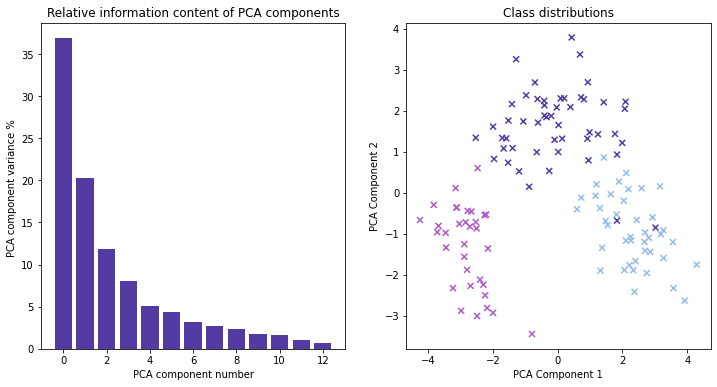

In [23]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
pca1 = X_train_pca[:, 0]
pca2 = X_train_pca[:, 1]

fig = plt.figure(figsize=(12,6))

fig.add_subplot(1,2,1)
plt.bar(np.arange(pca.n_components_), 100*pca.explained_variance_ratio_)
plt.title('Relative information content of PCA components')
plt.xlabel("PCA component number")
plt.ylabel("PCA component variance % ")

fig.add_subplot(1,2,2)
plt.scatter(pca1, pca2, c=y_train, marker='x', cmap=cmap2)
plt.title('Class distributions')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

In [24]:
pd.DataFrame(X_train_pca).iloc[:, 0:3]

,0,1,2
0,2.106742,-1.168626,-0.312493
1,2.748772,-1.958070,-0.716449
2,2.439928,-0.665089,-2.078583
3,1.243590,1.427265,1.427250
4,2.699185,-0.970803,0.680791
...,...,...,...
119,1.832497,0.931074,1.802628
120,-3.454884,-0.976261,-0.306899
121,2.072449,2.049156,-0.024045
122,-0.605487,1.711426,0.878223


<a name='4-4-1'></a>
### 4.4.1 - Logistic regression with PCA features

In [25]:
lr_pca = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr_pca.fit(X_train_pca[:, 0:2], y_train)

LogisticRegression(multi_class='ovr')

In [26]:
dict_acc['Logistic regression with 2 PCA features'] = [lr_pca.score(X_train_pca[:, 0:2], y_train),
                                                       lr_pca.score(X_test_pca[:, 0:2], y_test)]

print('Training accuracy:', lr_pca.score(X_train_pca[:, 0:2], y_train))
print('Test accuracy:', lr_pca.score(X_test_pca[:, 0:2], y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


Text(0.5, 1.0, 'Logistic regression with PCA features')

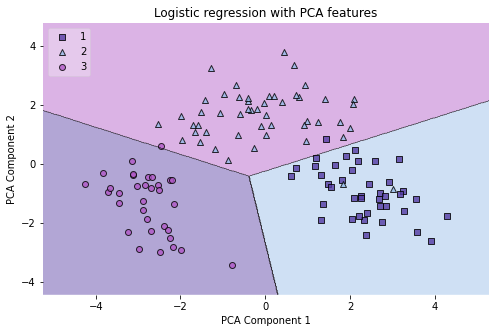

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_decision_regions(X_train_pca[:, 0:2], y_train, clf=lr_pca, legend=2, colors='#543ba3,#95bbe8,#b058c6', ax=ax)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Logistic regression with PCA features')

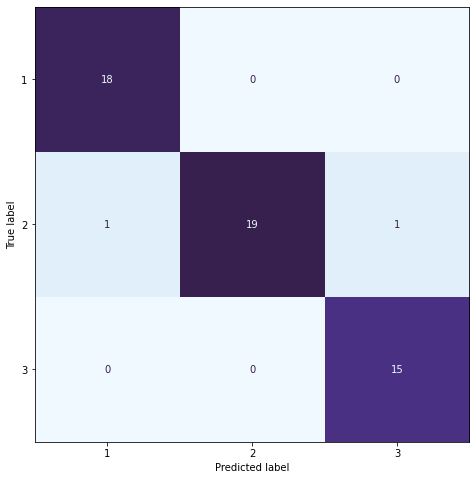

In [28]:
plot_cm(lr_pca, X_test_pca[:, 0:2], y_test)

In [29]:
print(classification_report(y_test, lr_pca.predict(X_test_pca[:, 0:2])))

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        18
           2       1.00      0.90      0.95        21
           3       0.94      1.00      0.97        15

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54



<a name='4-4-2'></a>
### 4.4.2 - KNN with PCA features

We will fit a k-nearest neighbors model with PCA features.

In [30]:
knn_pca = KNeighborsClassifier(n_neighbors=3)
knn_pca.fit(X_train_pca[:, 0:2], y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
dict_acc['KNN with 2 PCA features'] = [knn_pca.score(X_train_pca[:, 0:2], y_train),
                                       knn_pca.score(X_test_pca[:, 0:2], y_test)]

print('Training accuracy:', knn_pca.score(X_train_pca[:, 0:2], y_train))
print('Test accuracy:', knn_pca.score(X_test_pca[:, 0:2], y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9259259259259259


Text(0.5, 1.0, 'K-nearest neighbors with PCA features')

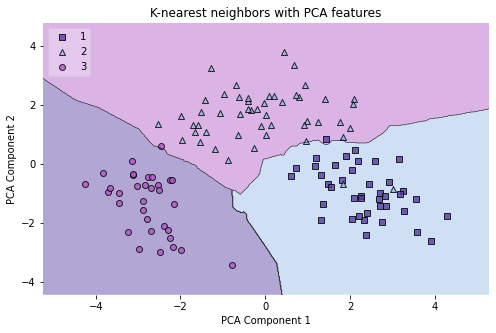

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_decision_regions(X_train_pca[:, 0:2], y_train, clf=knn_pca, legend=2, colors='#543ba3,#95bbe8,#b058c6', ax=ax)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-nearest neighbors with PCA features')

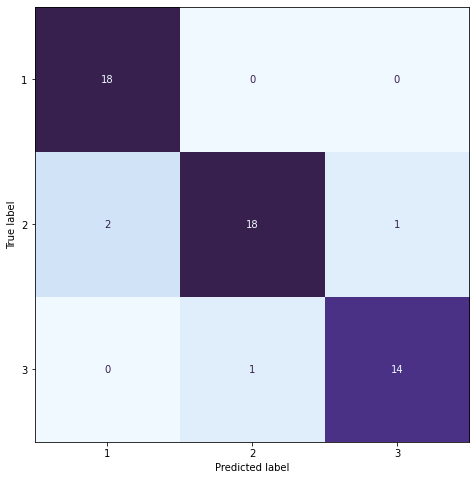

In [33]:
plot_cm(knn_pca, X_test_pca[:, 0:2], y_test)

<a name='4-5'></a>
## 4.5 - Fisher's linear discriminant analysis

Fisher's LDA is similar to PCA, but its main focus is on maximizing the separability among classes. LDA works by maximizing the distance between the means for each class, and minimizing scatter within a class.

Let us first consider a case with two classes.
Let

$$
\mu_k = \frac{1}{n_k} \sum_{i \in C_k} \textbf{x}_i \ \ (\text{mean of points in class }k),
$$

$$
S_k = \sum_{i \in C_k} (\textbf{x}_i - \mu_k)(\textbf{x}_i - \mu_k)^T \ \ (\text{covariance matrix of points in class }k).
$$

Means of the projected points are then defined as

$$
\hat{\mu}_k = \frac{1}{n_k} \sum_{i \in C_k} \hat{\textbf{x}}_i = \frac{1}{n_k} \sum_{i \in C_k} \textbf{w}^{T}\textbf{x}_i = \textbf{w}^{T}\mu_k.
$$

For each class we compute the variance (scatter matrix) of the projected points in one class

$$
\begin{aligned}
\hat{S}_k^2 &= \sum_{i \in C_k} (\hat{\textbf{x}}_i - \hat{\mu}_k)^2 \\
&= \sum_{i \in C_k} (\textbf{w}^{T}\textbf{x}_i - \textbf{w}^{T}\mu_k)^2 \\
&= \sum_{i \in C_k} (\textbf{w}^{T}\textbf{x}_i - \textbf{w}^{T}\mu_k)(\textbf{w}^{T}\textbf{x}_i - \textbf{w}^{T}\mu_k)^T \\
&= \sum_{i \in C_k} \textbf{w}^{T}(\textbf{x}_i - \mu_k)(\textbf{x}_i - \mu_k)^T \textbf{w} \\
&= \textbf{w}^{T} S_k \textbf{w}.
\end{aligned}
$$

We define the within-class variance (within-class scatter matrix) as the sum of scatter matrices for each class:

$$
S_W = \sum_k S_k;\ \  \hat{S}_W = \textbf{w}^{T} S_W \textbf{w}.
$$

We obtain the between class scatter matrix, by measuring the distance between cluster means:

$$
\hat{S}_B = (\hat{\mu}_2 - \hat{\mu}_1)^2 = (\textbf{w}^T\mu_2 - \textbf{w}^{T}\mu_1)^2 = \textbf{w}^{T} (\mu_2 - \mu_1)(\mu_2 - \mu_1)^T \textbf{w} = \textbf{w}^T S_B \textbf{w}.
$$

Now, we want to find such $\textbf{w}$, so that the within-class class variance is minimized, while the between-class variance is maximized, which is equivalent to finding $\textbf{w}$ such that:

$$
\textbf{w} = \text{argmax}_{\textbf{w}} \frac{\textbf{w}^T S_B \textbf{w}}{\textbf{w}^T S_W \textbf{w}}. 
$$


This is Rayleigh quotient optimization problem, which can solved using the method of Lagrange multipliers, by putting a constraint on $\textbf{w}^T S_W \textbf{w}$.

$$
\max_{\textbf{w}} \textbf{w}^T S_B \textbf{w}, \quad  \text{ subject to } \textbf{w}^T S_W \textbf{w} = 1.
$$

The Lagrangian is:

$$
L(\textbf{w}, \lambda) = \textbf{w}^T S_B \textbf{w} - \lambda(\textbf{w}^T S_W \textbf{w} - 1),
$$

$$
\begin{aligned}
\frac{\partial L}{\partial \textbf{w}} = 2 \textbf{w} S_B - 2\lambda S_W \textbf{w} &= 0 \\
S_B \textbf{w}  &= \lambda S_W \textbf{w}.
\end{aligned}
$$

If $S_W$ was not singular, then the solution would be an eigenvector of $S_W^{-1}S_B$. Notice that $S_W$ is a $p \times p$ covariance matrix. If $p < n$, then most likely $S_W$ is not singular. On the other hand $S_B$, which is also a $p \times p$ matrix, has rank 1, as a product of two vectors. 

Analogous derivation can be obtained in case of multiple classes.

In [34]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

Text(0, 0.5, 'LDA Component 2')

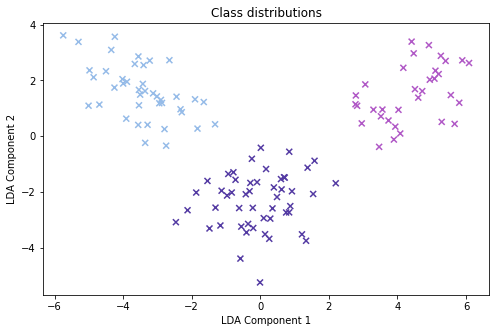

In [35]:
lda1 = X_train_lda[:, 0]
lda2 = X_train_lda[:, 1]

plt.figure(figsize=(8, 5))
plt.scatter(lda1, lda2, c=y_train, marker='x', cmap=cmap2)
plt.title('Class distributions')
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")

We see that the Fisher's linear discriminant analysis is much better than PCA at keeping the classes separate.

<a name='4-5-1'></a>
### 4.5.1 - Logistic regression with LDA features

In [36]:
lr_lda = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr_lda = lr.fit(X_train_lda, y_train)

Text(0.5, 1.0, 'Logistic regression with LDA features')

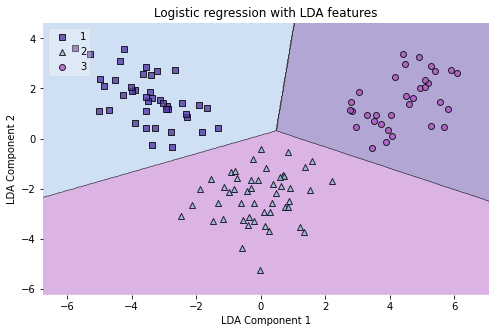

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_decision_regions(X_train_lda, y_train, clf=lr_lda, legend=2, colors='#543ba3,#95bbe8,#b058c6', ax=ax)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('Logistic regression with LDA features')

In [38]:
dict_acc['Logistic Regression with LDA features'] = [lr_lda.score(X_train_lda, y_train),
                                                     lr_lda.score(X_test_lda, y_test)]

print('Training accuracy:', lr_lda.score(X_train_lda, y_train))
print('Test accuracy:', lr_lda.score(X_test_lda, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


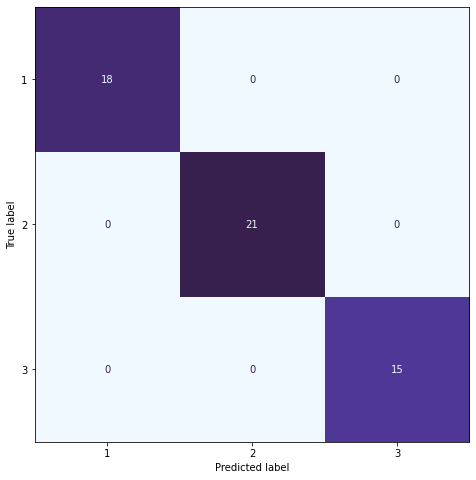

In [39]:
plot_cm(lr_lda, X_test_lda, y_test)

<a name='4-5-2'></a>
### 4.5.2 - KNN with LDA features

In [40]:
knn_lda = KNeighborsClassifier(n_neighbors=3)
knn_lda = knn_lda.fit(X_train_lda, y_train)

Text(0.5, 1.0, 'KNN with LDA features')

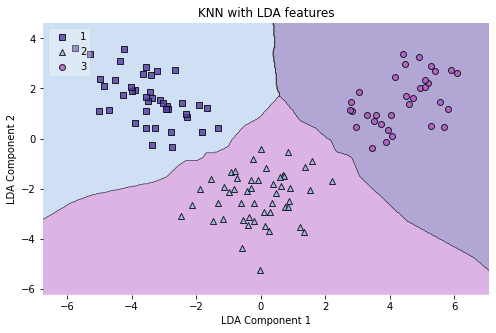

In [41]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_decision_regions(X_train_lda, y_train, clf=knn_lda, legend=2, colors='#543ba3,#95bbe8,#b058c6', ax=ax)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('KNN with LDA features')

In [42]:
dict_acc['KNN with LDA features'] = [knn_lda.score(X_train_lda, y_train),
                                     knn_lda.score(X_test_lda, y_test)]

print('Training accuracy:', knn_lda.score(X_train_lda, y_train))
print('Test accuracy:', knn_lda.score(X_test_lda, y_test))

Training accuracy: 1.0
Test accuracy: 0.9814814814814815


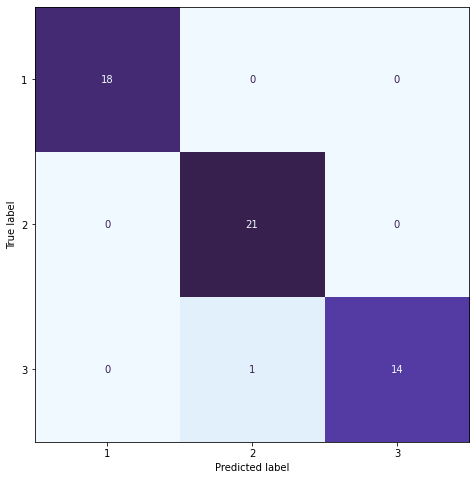

In [43]:
plot_cm(knn_lda, X_test_lda, y_test)

<a name='4-6'></a>
## 4.6 - Random forest classifier

<a name='4-6-1'></a>
### 4.6.1 - Decision tree

In a decision tree we want to split the data at each node, so that the impurity is minimized (most of the datapoints in a node are of the same class).

Let $S = \{(\textbf{x}_1, y_1), \dots, (\textbf{x}_n, y_n) \}$ be the set of all datapoints in a leaf. Then $S_k = \{(\textbf{x}, y) \in S : y = k\}$ - all inputs with labels $k$.  
Define:

$$
p_k = \frac{|S_k|}{|S|}  - \text{fraction of inputs in } S \text{ with label } k.
$$

Additionally let $S_L$ and $S_R$ denote all the inputs in the left and right subtree, respectively. The fraction of points will then be $p_L = \frac{|S_L|}{|S|}$ for the left subtree, and $p_R = \frac{|S_R|}{|S|}$ for the right subtree.

When deciding on a split in a decision tree, the worst-case scenario is when the distribution over all possible classes is uniform. In such case our model doesn't learn anything about the data, and is no better than a random coin toss.

The *Kullback–Leibler divergence* (also called relative entropy), is a measure of how one probability distribution $p$ is different from a second, reference probability distribution $q$.

$$
KL(p || q) = E_p\left[ \log \frac{p(X)}{q(X)} \right] = \sum_x p(x) \log \frac{p(x)}{q(x)}.
$$

In  order to find optimal split we want the distribution of the classes in a node to be as different as possible form the uniform distribution $q_1 = q_2 = \dots = q_K = \frac{1}{K}$. Kullback–Leibler divergence is

$$
KL(p || \frac{1}{K}) = \sum_{k=1}^{K} p_k \log \frac{p_k}{1/K} = \sum_{k=1}^{K} p_k \log p_k + \sum_{k=1}^{K} p_k \log K = \sum_{k=1}^{K} p_k \log p_k + \log K.
$$

Since the second term is just a constant, we want to maximize

$$
\max \sum_{k=1}^{K} p_k \log p_k,
$$

or equivalently minimize

$$
\min -\sum_{k=1}^{K} p_k \log p_k = \min H.
$$

The value $H$ is called *entropy*, or measure of uncertainty.

Entropy over a tree:

$$
H(\text{Tree}) = p_L H(S_L) + p_R H(S_R).
$$

They we set up our tree is by exhaustively checking each possible split.

<a name='4-6-2'></a>
### 4.6.2 - Bagging

Given a standard training set $D$ of size $n$, bagging generates $m$ new training sets $D_{i}$, each of size $n'$, by sampling from $D$ uniformly and with replacement. This kind of sample is known as a *bootstrap sample*. Sampling with replacement ensures each bootstrap is independent from its peers, as it does not depend on previous chosen samples when sampling. Then, m models are fitted using the above m bootstrap samples and combined by averaging the output (for regression) or voting (for classification). 

Bagging significantly reduces variance of the classifier. Let $h_D(x)$ denote the classifier we learned based on the training data. The variance of our model then is

$$
E[(h_D(x) - E[h_D(x)])^2]. 
$$

From the weak law of large numbers we have

$$
\lim_{m \rightarrow \infty} \frac{1}{m} \sum_{i=1}^m h_{D_i}(x) = E[h_D(x)].
$$

<a name='4-6-3'></a>
### 4.6.3 - Random forest

A Random Forest is essentially nothing else but bagged decision trees, with a slightly modified splitting criteria.

The algorithm works as follows:

1. Sample $m$ data sets $D_1, \dots ,D_m$ from $D$ with replacement.
2. For each $D_j$ train a full decision tree classifier $h_j()$ (max-depth=$\infty$) with one small modification: before each split randomly subsample $k \leq d$ features (without replacement) and only consider these for your split. (This further increases the variance of the trees.)
3. The final classifier is $h(x)= \frac{1}{m} \sum_{j=1}^m h_j(x)$


In [44]:
forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

In [45]:
importances

array([0.12280706, 0.0477659 , 0.01360492, 0.02461787, 0.03022661,
       0.0592766 , 0.1530873 , 0.01702495, 0.02311209, 0.15234583,
       0.06350087, 0.11150148, 0.18112852])

In [46]:
indices = np.argsort(importances)[::-1]

In [47]:
features = wine_data.columns[1:]

In [48]:
importances[indices]

array([0.18112852, 0.1530873 , 0.15234583, 0.12280706, 0.11150148,
       0.06350087, 0.0592766 , 0.0477659 , 0.03022661, 0.02461787,
       0.02311209, 0.01702495, 0.01360492])

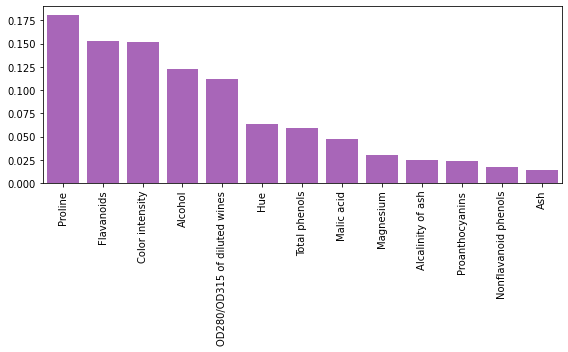

In [49]:
plt.figure(figsize=(8, 5))
sns.barplot(x=features[indices], y=importances[indices], color='#b058c6')
plt.xticks(rotation=90)
plt.tight_layout()

In [50]:
dict_acc['Random forest'] = [forest.score(X_train, y_train),
                             forest.score(X_test, y_test)]

print('Training accuracy:', forest.score(X_train, y_train))
print('Test accuracy:', forest.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.9814814814814815


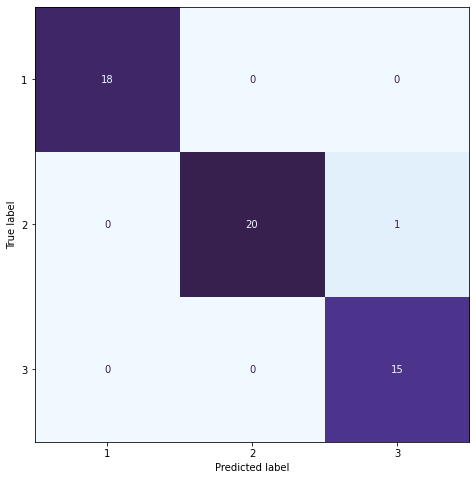

In [51]:
plot_cm(forest, X_test, y_test)

<a name='4-6-4'></a>
### 4.6.4 - Hyperparameter tuning

Unlike previous methods we've used the random forest classifier has a fair number of hyperparameters that can be tuned for better prediction accuracy.

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [52]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

In [53]:
forest_cv = RandomForestClassifier()
cv_rf = GridSearchCV(estimator=forest_cv, param_grid=param_grid, cv=5)

cv_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [54]:
cv_rf.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [55]:
cv_rf.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=200)

In [56]:
forest_cv_best = cv_rf.best_estimator_

In [57]:
forest_cv_best.score(X_test, y_test)

0.9814814814814815

<a name='5'></a>
# 5 - Summary

In [58]:
summary_table = pd.DataFrame(data=dict_acc.values(), 
                             columns=['Train accuracy', 'Test accuracy'], 
                             index=dict_acc.keys())

In [59]:
summary_table

,Train accuracy,Test accuracy
Logistic regression,1.000000,0.962963
KNN,0.967742,0.944444
Logistic regression with 2 PCA features,0.967742,0.962963
KNN with 2 PCA features,0.967742,0.925926
Logistic Regression with LDA features,1.000000,1.000000
KNN with LDA features,1.000000,0.981481
Random forest,1.000000,0.981481


# References

- [Cornell - CS4780 lecture notes](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/)
- Sebastian Raschka - Python Machine Learning, 3rd Ed